In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

In [186]:
fire_df = pd.read_csv("../Resources/fire_data/fire_all_clean.csv", index_col="City_ID")
fire_df.head()

# fire_duplicates = fire_df[['Year','Month', 'County']].duplicated()
# fire_df[fire_duplicates]

#THERE ARE MULTIPLE FIRES IN YEAR/MONTH/COUNTY. 
#Therefore you need to group by month and summarize the data per month.

#select columns
filtered_fire = fire_df[["Year", "Month", "County", "Acres burned", "Duration (days)"]]

#drop "days" and concert to int
filtered_fire.loc[:, "Duration (days)"] = pd.to_numeric(filtered_fire["Duration (days)"].str.extract('(\d+)')[0], errors="coerce")

#groupby
filtered_fire=filtered_fire.groupby(['Year','Month', 'County'])

#filtered_fire.head()

#calc acres avg
acres_burned_avg = filtered_fire["Acres burned"].mean()

#calc rounded avg days
duration_days_avg = filtered_fire["Duration (days)"].mean()

#sum count of incidents
tot_fire_incidents = filtered_fire["Acres burned"].count()

summary_fire = pd.DataFrame({
    "Acres Burned Avg": acres_burned_avg,
    "Fire Duration Avg (days)": duration_days_avg,
    "Incident Count Tot": tot_fire_incidents
 })

summary_fire = summary_fire.reset_index()

#drop 2024 and 1969
final_fire = summary_fire.loc[(summary_fire["Year"]>=2013) & (summary_fire["Year"]<2024)]
final_fire

,Year,Month,County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot
3,2013,April,Madera,274.0,1.0,1
4,2013,April,Napa,75.0,1.0,1
5,2013,April,San Bernardino,30.0,2.0,1
6,2013,August,Butte,812.0,3.333333,3
7,2013,August,Calaveras,46.0,2.0,1
...,...,...,...,...,...,...
1157,2023,October,Solano,36.0,3.0,1
1158,2023,September,Calaveras,32.0,2.0,1
1159,2023,September,Kern,55.0,1.0,1
1160,2023,September,Lake,28.0,5.0,1


In [187]:
final_fire.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159 entries, 3 to 1161
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1159 non-null   int64  
 1   Month                     1159 non-null   object 
 2   County                    1159 non-null   object 
 3   Acres Burned Avg          1159 non-null   float64
 4   Fire Duration Avg (days)  1159 non-null   object 
 5   Incident Count Tot        1159 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 63.4+ KB


In [188]:
rainfall_df = pd.read_csv("../Resources/weather_data/rainfall_all_years_clean.csv", index_col="City_ID")
filtered_rain = rainfall_df[["County", "Year", "Month", "Rainfall (inches)"]]
filtered_rain.head()

# rain_duplicates = filtered_rain.duplicated()
# print(filtered_rain[rain_duplicates])
# NO DUPLICATES

,County,Year,Month,Rainfall (inches)
City_ID,,,,
0,Alameda,2013,March,0.63
1,Alpine,2013,March,2.56
2,Amador,2013,March,2.89
3,Butte,2013,March,2.57
4,Calaveras,2013,March,2.75


In [189]:
filtered_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7830 entries, 0 to 7829
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   County             7830 non-null   object 
 1   Year               7830 non-null   int64  
 2   Month              7830 non-null   object 
 3   Rainfall (inches)  7830 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 305.9+ KB


In [190]:
temperature_df = pd.read_csv("../Resources/weather_data/temperature_all_years_clean.csv", index_col="City_ID")
filtered_temp=temperature_df[["County", "Year", "Month", "Temperature (F)"]]

In [191]:
filtered_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7772 entries, 0 to 7771
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   County           7772 non-null   object 
 1   Year             7772 non-null   int64  
 2   Month            7772 non-null   object 
 3   Temperature (F)  7772 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 303.6+ KB


In [192]:
temp_duplicates = filtered_temp[["County","Month", "Year"]].duplicated()
# print(filtered_temp[temp_duplicates])
## 522 duplicates

clean_temp = filtered_temp[["County","Month", "Year"]].drop_duplicates()
clean_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7250 entries, 0 to 7771
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   County  7250 non-null   object
 1   Month   7250 non-null   object
 2   Year    7250 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 226.6+ KB


In [193]:
fire_rain = pd.merge(final_fire, filtered_rain, on=["Month", "Year", "County"], how="left")
fire_rain.tail()

,Year,Month,County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
1154,2023,October,Solano,36.0,3.0,1,0.44
1155,2023,September,Calaveras,32.0,2.0,1,0.48
1156,2023,September,Kern,55.0,1.0,1,0.02
1157,2023,September,Lake,28.0,5.0,1,0.39
1158,2023,September,Napa,14.0,1.0,1,0.17


In [194]:
fire_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1159 non-null   int64  
 1   Month                     1159 non-null   object 
 2   County                    1159 non-null   object 
 3   Acres Burned Avg          1159 non-null   float64
 4   Fire Duration Avg (days)  1159 non-null   object 
 5   Incident Count Tot        1159 non-null   int64  
 6   Rainfall (inches)         1117 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 63.5+ KB


In [195]:
fire_rain_temp = pd.merge(fire_rain, clean_temp, on=["Month", "Year", "County"], how="left")
fire_rain_temp.tail()

,Year,Month,County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
1154,2023,October,Solano,36.0,3.0,1,0.44
1155,2023,September,Calaveras,32.0,2.0,1,0.48
1156,2023,September,Kern,55.0,1.0,1,0.02
1157,2023,September,Lake,28.0,5.0,1,0.39
1158,2023,September,Napa,14.0,1.0,1,0.17


In [196]:
fire_rain_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1159 non-null   int64  
 1   Month                     1159 non-null   object 
 2   County                    1159 non-null   object 
 3   Acres Burned Avg          1159 non-null   float64
 4   Fire Duration Avg (days)  1159 non-null   object 
 5   Incident Count Tot        1159 non-null   int64  
 6   Rainfall (inches)         1117 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 63.5+ KB


In [197]:
fire_rain_temp = fire_rain_temp.dropna()
fire_rain_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117 entries, 0 to 1158
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      1117 non-null   int64  
 1   Month                     1117 non-null   object 
 2   County                    1117 non-null   object 
 3   Acres Burned Avg          1117 non-null   float64
 4   Fire Duration Avg (days)  1117 non-null   object 
 5   Incident Count Tot        1117 non-null   int64  
 6   Rainfall (inches)         1117 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 69.8+ KB


In [198]:
fire_rain_temp.head()

,Year,Month,County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
0,2013,April,Madera,274.0,1.0,1,0.87
1,2013,April,Napa,75.0,1.0,1,1.05
2,2013,April,San Bernardino,30.0,2.0,1,0.02
3,2013,August,Butte,812.0,3.333333,3,0.03
4,2013,August,Calaveras,46.0,2.0,1,0.00


In [199]:
#stats

acres_stat = fire_rain_temp["Acres Burned Avg"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
fire_duration_stat = fire_rain_temp["Fire Duration Avg (days)"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
incident_stat = fire_rain_temp["Incident Count Tot"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])
rain_stat = fire_rain_temp["Rainfall (inches)"].agg(['mean', 'median', 'var', 'std', 'sem', 'max'])

stats_summary = pd.DataFrame({
    "Acres Burned Stats": acres_stat,
    "Fire Duration Stats (days)": fire_duratino_stat,
    "Incident Count Stats": incident_stat,
    "Rainfall Stats (inches)": rain_stat
 })

stats_summary

#use mean to filter data for counties

,Acres Burned Stats,Fire Duration Stats (days),Incident Count Stats,Rainfall Stats (inches)
mean,2.622785e+03,54.166917,1.696509,0.460152
median,1.260000e+02,5.000000,1.000000,0.070000
var,1.569668e+08,6419.723654,1.754585,1.405243
std,1.252864e+04,80.123178,1.324607,1.185429
sem,3.748671e+02,2.397351,0.039633,0.035469
max,2.231240e+05,392.000000,16.000000,15.790000


In [200]:
#SUFFER = acres burned, number of incidents

filtered_counties_df = fire_rain_temp.loc[(fire_rain_temp["Acres Burned Avg"]>stats_summary.loc["median", "Acres Burned Stats"]) \
                & (fire_rain_temp["Incident Count Tot"]>stats_summary.loc["median", "Incident Count Stats"])\
                & (fire_rain_temp["Fire Duration Avg (days)"]>stats_summary.loc["median", "Fire Duration Stats (days)"])]

filtered_counties_df["Fire Duration Avg (days)"] = filtered_counties_df["Fire Duration Avg (days)"].astype(int)
filtered_counties_df

/var/folders/_7/hzy3hwcs7q72sm8v1h1k2rq80000gn/T/ipykernel_1218/2463313283.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_counties_df["Fire Duration Avg (days)"] = filtered_counties_df["Fire Duration Avg (days)"].astype(int)


,Year,Month,County,Acres Burned Avg,Fire Duration Avg (days),Incident Count Tot,Rainfall (inches)
19,2013,August,Tuolumne,129192.000000,14,2,0.10
99,2014,August,Los Angeles,232.000000,118,2,0.14
100,2014,August,Madera,311.000000,57,2,0.12
116,2014,July,Modoc,5424.333333,6,3,0.29
121,2014,July,Shasta,15214.833333,27,6,0.10
...,...,...,...,...,...,...,...
1077,2022,June,Tehama,346.500000,5,2,1.07
1085,2022,May,Riverside,1987.333333,125,3,0.00
1097,2022,September,Siskiyou,2118.000000,9,2,0.79
1112,2023,August,Siskiyou,11304.500000,46,2,0.74


In [201]:
filtered_counties_list = filtered_counties["County"].unique().tolist()

In [202]:
county_dfs = {}
for x in filtered_counties_list:
    county_dfs[f'df_{x}'] = filtered_counties_df.loc[(filtered_counties_df["County"] == x)]
    
county_dfs.keys()

dict_keys(['df_Tuolumne', 'df_Los Angeles', 'df_Madera', 'df_Modoc', 'df_Shasta', 'df_Siskiyou', 'df_El Dorado', 'df_San Bernardino', 'df_Tulare', 'df_Butte', 'df_Humboldt', 'df_Kern', 'df_Monterey', 'df_Santa Barbara', 'df_Santa Clara', 'df_Fresno', 'df_Riverside', 'df_Lassen', 'df_Mariposa', 'df_Plumas', 'df_San Diego', 'df_San Luis Obispo', 'df_Trinity', 'df_Contra Costa', 'df_Mendocino', 'df_Stanislaus', 'df_Lake', 'df_Nevada', 'df_Sonoma', 'df_Calaveras', 'df_Alameda', 'df_Inyo', 'df_San Benito', 'df_Tehama', 'df_Glenn', 'df_Merced', 'df_Orange', 'df_San Joaquin', 'df_Ventura'])

In [211]:
calc_cols = ["Acres Burned Avg", "Fire Duration Avg (days)", "Incident Count Tot","Rainfall (inches)"]
stats = [] # for loop
stat_plot = [] # to append 

# for y in county_dfs:
for county in county_dfs:
# Create empty list to fill
    #filter for specific county df and col calculation
    df = county_dfs[county]["Acres Burned Avg"]

    quartiles = df.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = round(upperq-lowerq, 2)

    stats = list(df)

    # Determine outliers using upper and lower bounds
    lower_bound = round(lowerq - (1.5*iqr), 2)
    upper_bound = round(upperq + (1.5*iqr), 2)

    stat_plot.append(stats)

    stat_plot

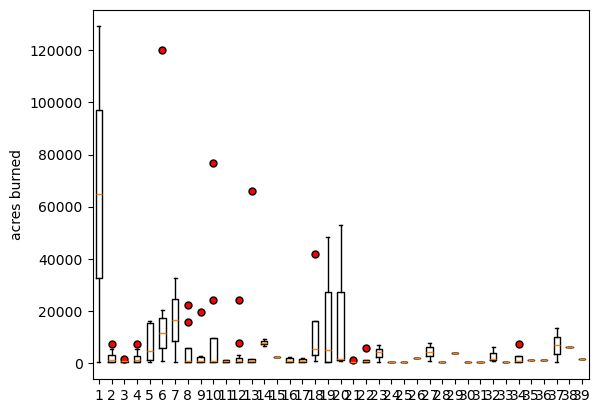

In [237]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
fig1, ax1 = plt.subplots()
flierprops = dict(marker= "o", markerfacecolor= "red", markeredgecolor= "black", markersize= "5")
ax1.boxplot(stat_plot, flierprops=flierprops)
ax1.set_ylabel('acres burned')
x_axis = np.arange(1, len(county_dfs)+1)
tick_locations = []
plt.subplots_adjust()
plt.figure(figsize=(500, 100))
for x in x_axis:
     tick_locations.append(x)
plt.xticks(tick_locations, county_dfs, rotation=45)
plt.show()

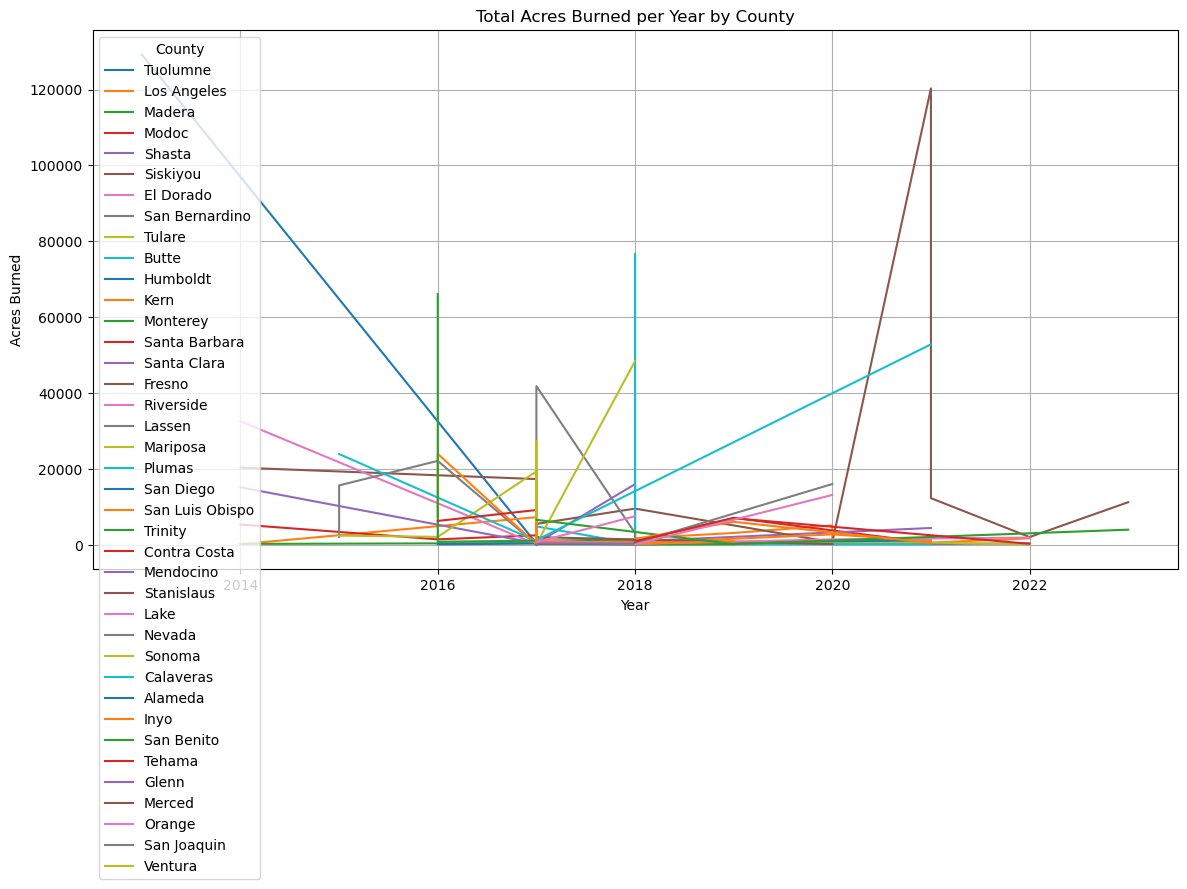

Ventura


In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for county in filtered_counties_list:
    x_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Year'].tolist()
    y_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Acres Burned Avg'].tolist()
    plt.plot(x_values, y_values, label=county)

plt.title('Total Acres Burned per Year by County')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.legend(title='County')
plt.grid(True)
plt.show()
print(x)


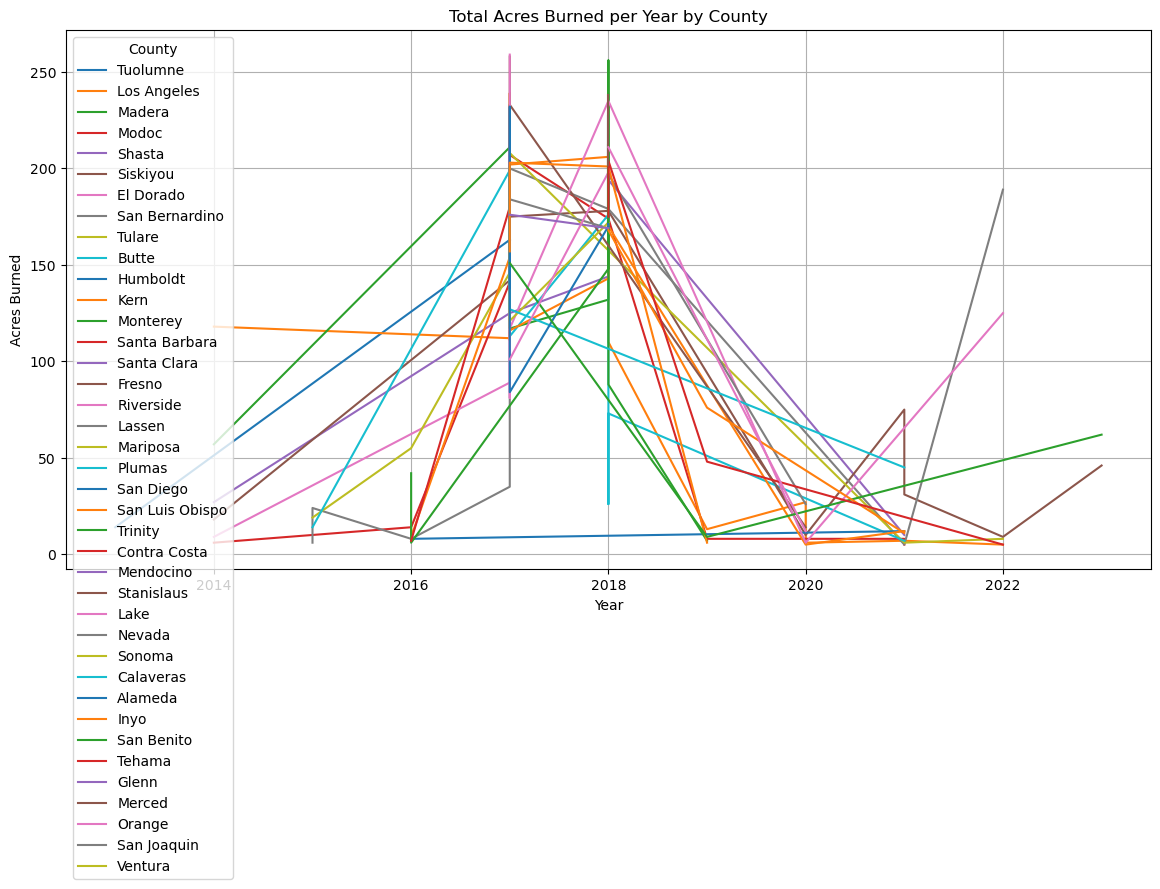

39


In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for county in filtered_counties_list:
    x_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Year'].tolist()
    y_values = filtered_counties_df.loc[filtered_counties_df['County'] == county, 'Fire Duration Avg (days)'].tolist()
    plt.plot(x_values, y_values, label=county)

plt.title('Total Acres Burned per Year by County')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.legend(title='County')
plt.grid(True)
plt.show()
print(x)


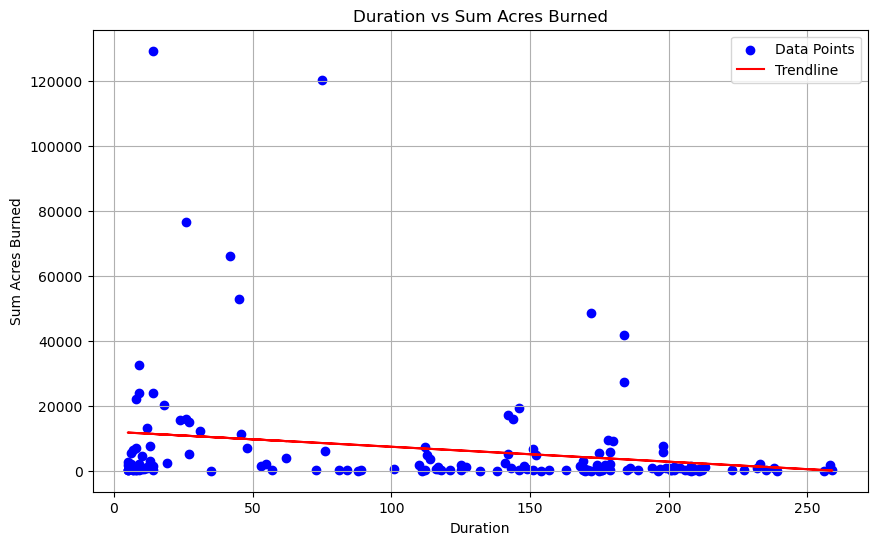

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Data
duration = filtered_counties_df['Fire Duration Avg (days)']
acres_burned = filtered_counties_df['Acres Burned Avg']

# Fit a trendline (linear regression)
#slope, intercept = np.polyfit(rainfall, acres_burned, 1)
result = stats.linregress(duration, acres_burned)
slope, intercept, r = result.slope, result.intercept, result.rvalue

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(duration, acres_burned, color='blue', label='Data Points')
plt.plot(duration, slope * duration + intercept, color='red', label='Trendline')

# Labels and title
plt.xlabel('Duration')
plt.ylabel('Sum Acres Burned')
plt.title('Duration vs Sum Acres Burned')
plt.legend()

plt.annotate(f'r={r}', (50, 1e6), color="r")

# Show plot
plt.grid(True)
plt.show()